# Logistic Regression: Predicting High-Income Earners

https://docs.google.com/document/d/1yKFK8f0Rvm4SfkCN1NB68EK0wkcEp1Ae-4p4vgGdCAw/edit

## Introduction

Income prediction is a significant area of study in economics and machine learning. It involved predicting an individual's income level based on various demographic and socioeconomic factors. This is crucial for policy-making, resource allocation and understanding economic disparities. 

**The main question I am answering is: Can an individual's age, years of education, occupation, sex, and hours per week be used as reliable predictors for determining whether their annual income will be greater than $50,000 in the United States?**

The dataset used for the study is the "Adult" dataset also known as the "Census Income" dataset. This dataset was donated on 4/30/1996 and extracted by Barry Becker from the 1994 Census database. It has been preprocessed so that reasonably clean records are selected and is commonly used for classification tasks. It includes attributes such as  age, workclass, fnlwgt, education, education-num, marital status, occupation, relationship, race, sex, capital gain, capital loss, hours-per-week, and native country.

**Citation:**

Becker, Barry and Kohavi, Ronny. (1996). Adult. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20

## Preliminary Exploratory Data Analysis

### Loading Packages

In [1]:
library(tidyverse)
library(AER)
library(pROC)
library(caret)

set.seed(99999)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival


### Reading the Data

I used the `read_delim()` function to read the file from the web and removed any additional whitespace that was present in all the character columns in this dataset.

In [2]:
census_data <- read_delim("data/adult.data", delim = ",", col_names = FALSE) %>% 
    mutate(across(where(is.character), trimws))

Rows: 32561 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15
dbl  (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


To get the dataset I wanted to work with, I first needed to filter out the unnecessary columns. Then, I cleaned up the column names for better readability and changed the data types of each column to their appropriate formats for better data handling.

In [3]:
census_data <- select(census_data, X1, X5, X7, X10, X13, X15)

names(census_data) <- c("age", "education_num","occupation", "sex", "hours_per_week", "income")

census_data$age <- as.integer(census_data$age)
census_data$education_num <- as.integer(census_data$education_num)
census_data$occupation <- as.factor(census_data$occupation)
census_data$sex <- as.factor(census_data$sex)
census_data$hours_per_week <- as.integer(census_data$hours_per_week)
census_data$income <- ifelse(census_data$income == "<=50K", 0, 1)

print("Table 1: Representation of the Initial Dataset")
head(census_data)

[1] "Table 1: Representation of the Initial Dataset"


age,education_num,occupation,sex,hours_per_week,income
<int>,<int>,<fct>,<fct>,<int>,<dbl>
39,13,Adm-clerical,Male,40,0
50,13,Exec-managerial,Male,13,0
38,9,Handlers-cleaners,Male,40,0
53,7,Handlers-cleaners,Male,40,0
28,13,Prof-specialty,Female,40,0
37,14,Exec-managerial,Female,40,0


After reviewing the summary statistics for all the variables, I found that there was a class imbalance in the response variable `income` in that over 75% of the individuals had an annual income below $50K, as indicated by the third quantile.

In [4]:
summary(census_data)

      age        education_num             occupation       sex       
 Min.   :17.00   Min.   : 1.00   Prof-specialty :4140   Female:10771  
 1st Qu.:28.00   1st Qu.: 9.00   Craft-repair   :4099   Male  :21790  
 Median :37.00   Median :10.00   Exec-managerial:4066                 
 Mean   :38.58   Mean   :10.08   Adm-clerical   :3770                 
 3rd Qu.:48.00   3rd Qu.:12.00   Sales          :3650                 
 Max.   :90.00   Max.   :16.00   Other-service  :3295                 
                                 (Other)        :9541                 
 hours_per_week      income      
 Min.   : 1.00   Min.   :0.0000  
 1st Qu.:40.00   1st Qu.:0.0000  
 Median :40.00   Median :0.0000  
 Mean   :40.44   Mean   :0.2408  
 3rd Qu.:45.00   3rd Qu.:0.0000  
 Max.   :99.00   Max.   :1.0000  
                                 

After reviewing the dataset's structure, I identified an instance of missing values, which appeared as "?" in the column for `occupation`.

In [5]:
str(census_data)

tibble [32,561 × 6] (S3: tbl_df/tbl/data.frame)
 $ age           : int [1:32561] 39 50 38 53 28 37 49 52 31 42 ...
 $ education_num : int [1:32561] 13 13 9 7 13 14 5 9 14 13 ...
 $ occupation    : Factor w/ 15 levels "?","Adm-clerical",..: 2 5 7 7 11 5 9 5 11 5 ...
 $ sex           : Factor w/ 2 levels "Female","Male": 2 2 2 2 1 1 1 2 1 2 ...
 $ hours_per_week: int [1:32561] 40 13 40 40 40 40 16 45 50 40 ...
 $ income        : num [1:32561] 0 0 0 0 0 0 0 1 1 1 ...


### Variables Description Summary

This is an overall summary of what I have discovered so far.

| Variable Name       | Type         | Description                                                   | Missing Values? |
|---------------------|--------------|---------------------------------------------------------------|-----------------|
| `age`               | Integer      | The age of the individual                                     | No              | 
| `education_num`     | Integer      | The number of years of education achieved by an individual    | No              |
| `occupation`        | Categorical  | The occupation of an individual                               | Yes             |
| `sex`               | Binary       | The sex of an individual                                      | No              |
| `hours_per_week`    | Integer      | The number of hours an individual works per week              | No              |
| `income`            | Binary       | Whether an individual makes more than $50,000 annually        | No              |

The attributes for the dataset variables include:

- `age`: Continuous.
- `education-num`: Continuous.
- `occupation`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- `sex`: (Female, Male)
- `hours_per_week`: Continuous.
- `income`: (>50K, <=50K)

### Checking and Removing All the Missing Values in the Dataset

I used `contains_missing_values` to check if my dataset had any missing values, which appeared as "?" in all of its categorical columns.

In [6]:
contains_missing_values <- any(sapply(census_data, function(x) {
  is.factor(x) && "?" %in% levels(x)
}))

print(contains_missing_values)

[1] TRUE


Filtering through the dataset and removing all those missing values along with the unused  levels in all the categorical columns. 

In [7]:
census_data <- census_data %>%
  filter(!if_any(where(is.factor), ~ .x == "?"))

census_data <- census_data %>%
  mutate(across(where(is.factor), ~ fct_drop(.)))

summary(census_data)

      age        education_num             occupation       sex       
 Min.   :17.00   Min.   : 1.00   Prof-specialty :4140   Female: 9930  
 1st Qu.:28.00   1st Qu.: 9.00   Craft-repair   :4099   Male  :20788  
 Median :37.00   Median :10.00   Exec-managerial:4066                 
 Mean   :38.44   Mean   :10.13   Adm-clerical   :3770                 
 3rd Qu.:47.00   3rd Qu.:13.00   Sales          :3650                 
 Max.   :90.00   Max.   :16.00   Other-service  :3295                 
                                 (Other)        :7698                 
 hours_per_week      income     
 Min.   : 1.00   Min.   :0.000  
 1st Qu.:40.00   1st Qu.:0.000  
 Median :40.00   Median :0.000  
 Mean   :40.95   Mean   :0.249  
 3rd Qu.:45.00   3rd Qu.:0.000  
 Max.   :99.00   Max.   :1.000  
                                

Now, using the `contains_missing_values` again, it is confirmed that there are no more missing values in the dataset. 

In [8]:
contains_missing_values <- any(sapply(census_data, function(x) {
  is.factor(x) && "?" %in% levels(x)
}))

print(contains_missing_values)

[1] FALSE


**At this point, my data is tidy.**

Data is considered "tidy" when it is organized in a way that makes it easy to work with and perform analysis on. A tidy dataset has the following characteristics:

- Each variable is in a column.
- Each observation is in a row.
- Each value is a cell in the dataset.

### Taking a Sample from the Census Dataset to Work With 

Due to limited resources, I obtained a smaller sample of size 5000 using the `sample_n()` function, which can be more cost-effective and requires less computational power for the overall analysis. I also applied the stratified sampling approach to address the issue of class imbalance that I discovered earlier. 

In [9]:
sample_income1 <- census_data %>% 
  filter(income == 1) %>% 
  sample_n(size = 2500)

sample_income0 <- census_data %>% 
  filter(income == 0) %>% 
  sample_n(size = 2500)

sample_data <- bind_rows(sample_income1, sample_income0)

print("Table 2: Representation of a Sample from the Census Dataset")
head(sample_data)

table(sample_data$income)

[1] "Table 2: Representation of a Sample from the Census Dataset"


age,education_num,occupation,sex,hours_per_week,income
<int>,<int>,<fct>,<fct>,<int>,<dbl>
33,9,Sales,Male,45,1
31,14,Exec-managerial,Male,60,1
53,14,Prof-specialty,Female,35,1
56,15,Adm-clerical,Male,40,1
37,9,Machine-op-inspct,Male,36,1
49,9,Other-service,Female,40,1



   0    1 
2500 2500 

## Visualization

By plotting a barplot of annual income by sex, it was seen that there is a clear difference in the proportion of gender earnings with males surpassing females. This visualization suggested that there may be a pay gap between genders, however, this plot alone cannot be used to establish causality since there could be many other factors involved as well.

[1] "Fig.1: Barplot of Annual Income by Sex"


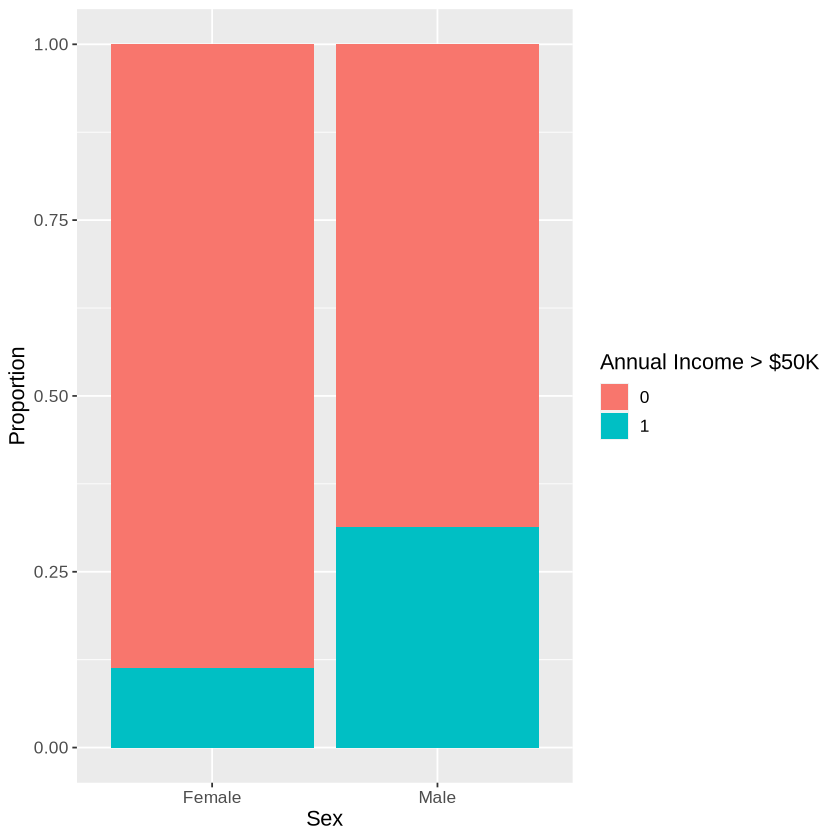

In [10]:
options(repr.plot.height = 7, repr.plot.width = 7)

ggplot(census_data, aes(x = sex, fill = factor(income))) + 
    geom_bar(position = "fill") + 
    labs(y = "Proportion", x = "Sex", fill = "Annual Income > $50K")  + 
    theme(text = element_text(size = 13))
print("Fig.1: Barplot of Annual Income by Sex")

By plotting a barplot of annual income by occupation, I noticed a distinct pattern in how income is distributed among different job roles. Roles such as `Exec-managerial` and `Prof-speciality` showed a significant portion of people earning more than $50K, which indicates that these occupations are among the higher-paid side within the dataset. On the other hand, roles such as `Priv-house-serv` and `Handlers-cleaners` were toward the lower compensation side. This visualization suggests that occupation type might be linked to income level, highlighting a potential occupational income gap. However, this plot alone cannot be used to establish causality since there could be many other factors that might influence income such as education level and the amount of hours worked.

`summarise()` has grouped output by 'occupation'. You can override using the
`.groups` argument.


[1] "Fig.2: Barplot of Annual Income by Occupation"


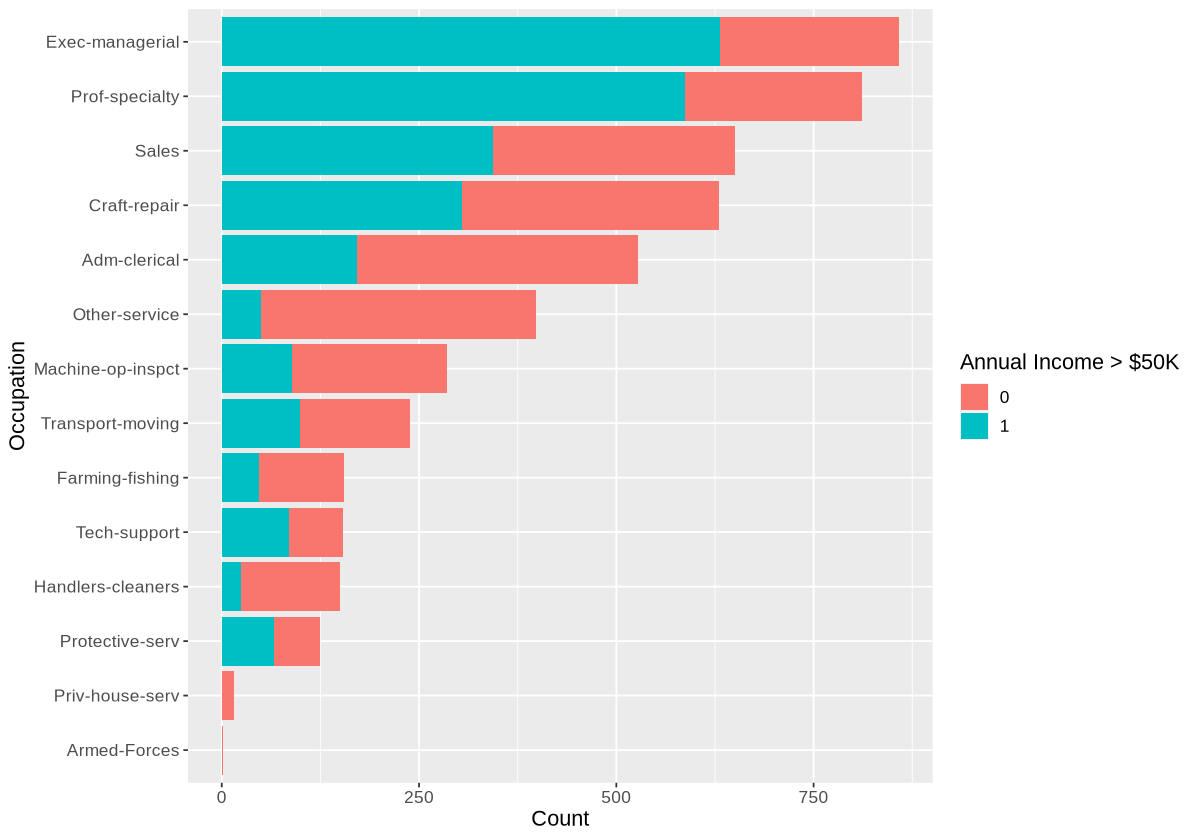

In [11]:
options(repr.plot.height = 7, repr.plot.width = 10)

occupation_count <- sample_data %>%
    group_by(occupation, income) %>%
    summarize(occupation_count = n()) 

ggplot(occupation_count, aes(x = reorder(occupation, occupation_count), y = occupation_count, fill = factor(income))) +
    geom_bar(stat = "identity") +
    coord_flip() + 
    labs(x = "Occupation", y = "Count") + 
    guides(fill = guide_legend(title = "Annual Income > $50K"))  + 
    theme(text = element_text(size = 13))
print("Fig.2: Barplot of Annual Income by Occupation")

By plotting a scatterplot that examined the relationship between hours worked per week and age, differentiated by year of education and gender, and colored by whether the individuals earn more than \\$50K annually, a complex interaction of factors influencing income became more apparent. This provided a good starting point for discussing more in-depth questions about what is actually influencing income. From this plot, it was seen that larger and more opaque dots, which represent a higher level of education were more predominantly seen in the plot representing income over \\$50K, especially among men ages 35 to 55 who work  40 to 60 hours a week. These patterns suggested that `education_num`, `sex`, `age`, and `hour_per_week `may play significant roles in achieving higher income levels. 


[1] "Fig.3: Scatterplot of Hours Per Week vs Age, colored by Annual Income > $50K, shaped by Sex, and sized by Level of Education,"


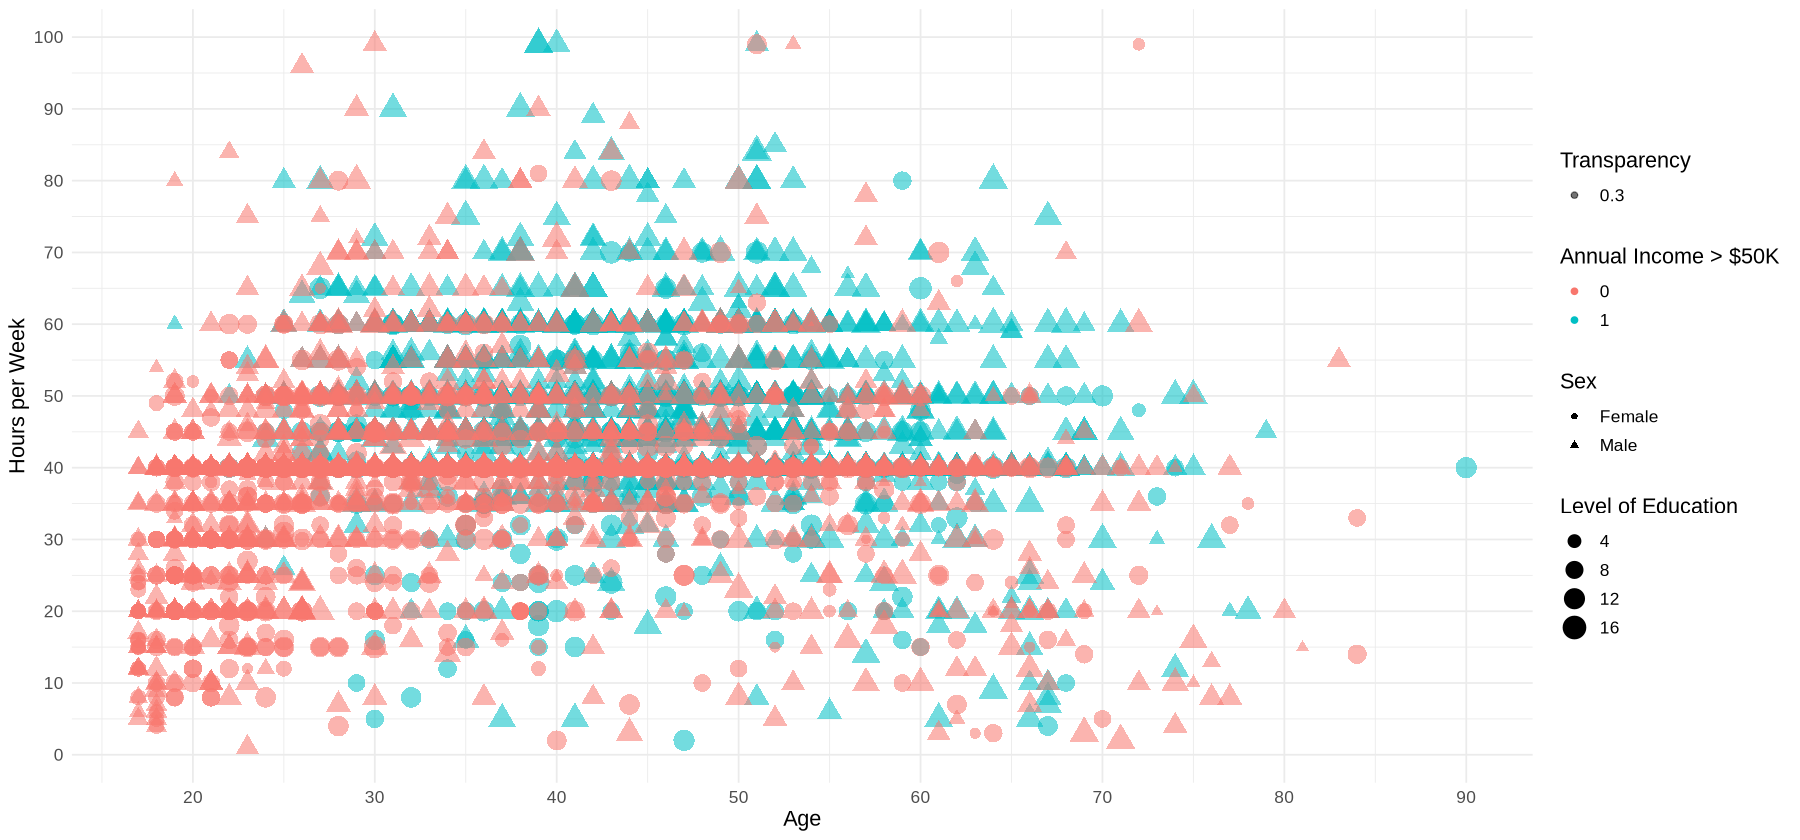

In [12]:
options(repr.plot.height = 7, repr.plot.width = 15)

ggplot(sample_data, aes(x = age, y = hours_per_week, shape = sex, color = factor(income))) + 
    geom_point(aes(size = education_num, alpha = 0.3)) + 
    labs(x = "Age", y = "Hours per Week") +
    guides(color = guide_legend(title = "Annual Income > $50K"), 
           shape = guide_legend(title = "Sex"), 
           size = guide_legend(title = "Level of Education"),
           alpha = guide_legend(title = "Transparency")) + 
    scale_x_continuous(breaks = seq(from = 0, to = 100, by = 10)) +
    scale_y_continuous(breaks = seq(from = 0, to = 100, by = 10)) +
    theme_minimal() + 
    theme(text = element_text(size = 13))
print("Fig.3: Scatterplot of Hours Per Week vs Age, colored by Annual Income > $50K, shaped by Sex, and sized by Level of Education,")

## Methods and Plan

### Method Chosen: 
Logistic Regression

### Why This Method is Appropriate: 
In this analysis, I have chosen logistic regression because it is very suitable for my question of interest, which aims to predict a binary outcome, that is, whether an individual's annual income exceeds \\$50,000 in the United States. This method excels in handling binary categorical dependent variables as well as incorporating various predictor variables. My predictor variables include both continuous data, like age and hours per week, and categorical data, like occupation and sex. Therefore, logistic regression allows me to assess the impact of these diverse variables on the probability of an individual earning more than \\$50,000 per year.  

To measure the performance of the estimated logistic regression I plan to use 2 methods of evaluation:

1. F1 Score: The F1-Score is a valuable metric that provides a balanced measure of a model's performance by considering both precision and recall. It is particularly useful in binary classification when you want to find a balance between making accurate positive predictions (high precision) and capturing all relevant positive instances (high recall). The F1-Score ranges from 0 to 1, where a high F1-Score indicates that the model have both high precision and high recall, meaning that it makes accurate positive predictions while capturing the most relevant positive instances. 

2. ROC Curve: The ROC-curve is a graphical tool used to visualize and assess the performance of a binary classification model across various classification thresholds. It plots the true positive rate (TPR) against the false positive rate (FPR), providing insights into the trade-off between sensitivity and specificity. The area under the ROC-curve is known as the AUC-score, which quantifies the overall performance of the model. A higher AUC-score indicates better discrimination ability. A perfect model with perfect classification would have an AUC-score of 1, while a random classifier would have an AUC-score of 0.5. 

It is important to note that the AUC-score considers all the thresholds along the ROC-curve, while the F1-score only considers a single threshold, which is 0.5 by default. Therefore, the AUC-score is useful for understanding the model’s ability to distinguish between classes across all thresholds, while the F1-score is useful for understanding the model’s trade-off between precision and recall at a specific threshold.


### Assumptions Required: 
When applying logistic regression, I am mindful of the following assumptions: 

- **Binary Dependent Variable:** This means that the outcome must fall into one of two categories, which aligns with my yes/no income categorization. 

- **Observations are Independent of Each Other:** This means that the data for one individual does not influence or relate to the data of another. 

- **Linearity of Independent Variable to Log Odds:** This means that there needs to be a linear relationship between the independent variable and the log odds of the dependent variable. 

- **Minimal or No Multicollinearity:** This means that the independent variables in my model should not be too highly correlated with each other.   

- **Large Sample Size:** This means that I need enough sample size in order to predict the outcome accurately.  

- **No Significant Outliers:** This means that outliers should not be present in my model as they could distort the prediction and lead to incorrect conclusions. 


### Potential Limitations or Weaknesses of the Method Selected: 
While logistic regression is powerful, it does have some limitations:

- **Causal Inference:** Logistic regression cannot be used to establish causation since it can only identify association.

- **Assumption Violations:** Any violations of logistic regression assumptions could introduce bias into my coefficient estimates providing misleading results.

- **Impact of Irrelevant Variables:** Including irrelevant variables can lead to overfitting and decrease model interpretability. Therefore, variable selection becomes crucial in order to maintain its efficiency. 

- **Predictive Power:** While logistic regression can indicate the odds of income being above $50,000 based on the predictors, it doesn't always mean high predictive accuracy. It is useful for understanding the relationship between the response and predictors, but there may be other unmeasured factors that influence income.

- **Non-Linearity:** Logistic regression assumes a linear relationship between the logit of the outcome and each predictor variable. If the relationships are non-linear, the model might not fit the data well without proper transformation of variables.

## Implementation of a Proposed Model

In [13]:
# Checking for Multicollinearity by Calculating the Variance Inflation Factor
vif_score <- round(vif(lm(formula = income ~ ., data = sample_data)), 3)
vif_score[, 3]

age  education_num     occupation            sex hours_per_week 
         1.032          1.242          1.027          1.126          1.062

In [14]:
# Splitting the Sample Dataset into 70% Training and 30% Testing 
sample_data$ID <- rownames(sample_data)

training_set <- sample_data %>% 
    sample_n(size = nrow(sample_data) * 0.70, replace = FALSE)

testing_set <- anti_join(sample_data, training_set, by = "ID") 

training_set <- training_set %>% 
    select(-"ID")
nrow(training_set)

testing_set <- testing_set %>% 
    select(-"ID")
nrow(testing_set)

[1] 3500

[1] 1500

In [15]:
# Fitting the Logistic Regression Model
model <- glm(income ~ ., data = training_set, family = binomial())

# Displaying the Model Summary
summary(model)


Call:
glm(formula = income ~ ., family = binomial(), data = training_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8737  -0.8406   0.2167   0.8182   2.7048  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -7.903008   0.365912 -21.598  < 2e-16 ***
age                           0.054898   0.003694  14.863  < 2e-16 ***
education_num                 0.272590   0.021304  12.795  < 2e-16 ***
occupationArmed-Forces      -13.950189 599.186976  -0.023 0.981425    
occupationCraft-repair        0.268462   0.175054   1.534 0.125130    
occupationExec-managerial     0.809253   0.166395   4.863 1.15e-06 ***
occupationFarming-fishing    -1.155446   0.281637  -4.103 4.09e-05 ***
occupationHandlers-cleaners  -0.551945   0.310174  -1.779 0.075163 .  
occupationMachine-op-inspct  -0.295077   0.222889  -1.324 0.185545    
occupationOther-service      -0.847164   0.243041  -3.486 0.000491 ***
occupationPriv-

In [16]:
# Predicting on the Testing Set
testing_set$predicted_prob <- predict(model, newdata = testing_set, type = "response")

# Converting the Probabilities to a Binary Outcome based on a 0.5 Threshold
testing_set$predicted_class <- ifelse(testing_set$predicted_prob > 0.5, ">50K", "<=50K")

# Converting to Factors to Match the Levels
testing_set$predicted_class <- factor(testing_set$predicted_class, levels = c("<=50K", ">50K"))
testing_set$income <- factor(ifelse(testing_set$income == 0, "<=50K", ">50K"), levels = c("<=50K", ">50K"))

# Creating a Confusion Matrix
conf_matrix <- confusionMatrix(testing_set$predicted_class, testing_set$income)
print(conf_matrix)

# Calculating the F1-score using Precision and Recall from the Confusion Matrix
precision <- conf_matrix$byClass['Pos Pred Value']
recall <- conf_matrix$byClass['Sensitivity']

f1_score <- 2 * (precision * recall) / (precision + recall)
print(paste("The F1-Score is:", f1_score))

Confusion Matrix and Statistics

          Reference
Prediction <=50K >50K
     <=50K   574  171
     >50K    187  568
                                          
               Accuracy : 0.7613          
                 95% CI : (0.7389, 0.7827)
    No Information Rate : 0.5073          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.5227          
                                          
 Mcnemar's Test P-Value : 0.4279          
                                          
            Sensitivity : 0.7543          
            Specificity : 0.7686          
         Pos Pred Value : 0.7705          
         Neg Pred Value : 0.7523          
             Prevalence : 0.5073          
         Detection Rate : 0.3827          
   Detection Prevalence : 0.4967          
      Balanced Accuracy : 0.7614          
                                          
       'Positive' Class : <=50K           
                     

Setting levels: control = <=50K, case = >50K

Setting direction: controls < cases



[1] "Fig.4: ROC Curves for Sample Census Dataset"


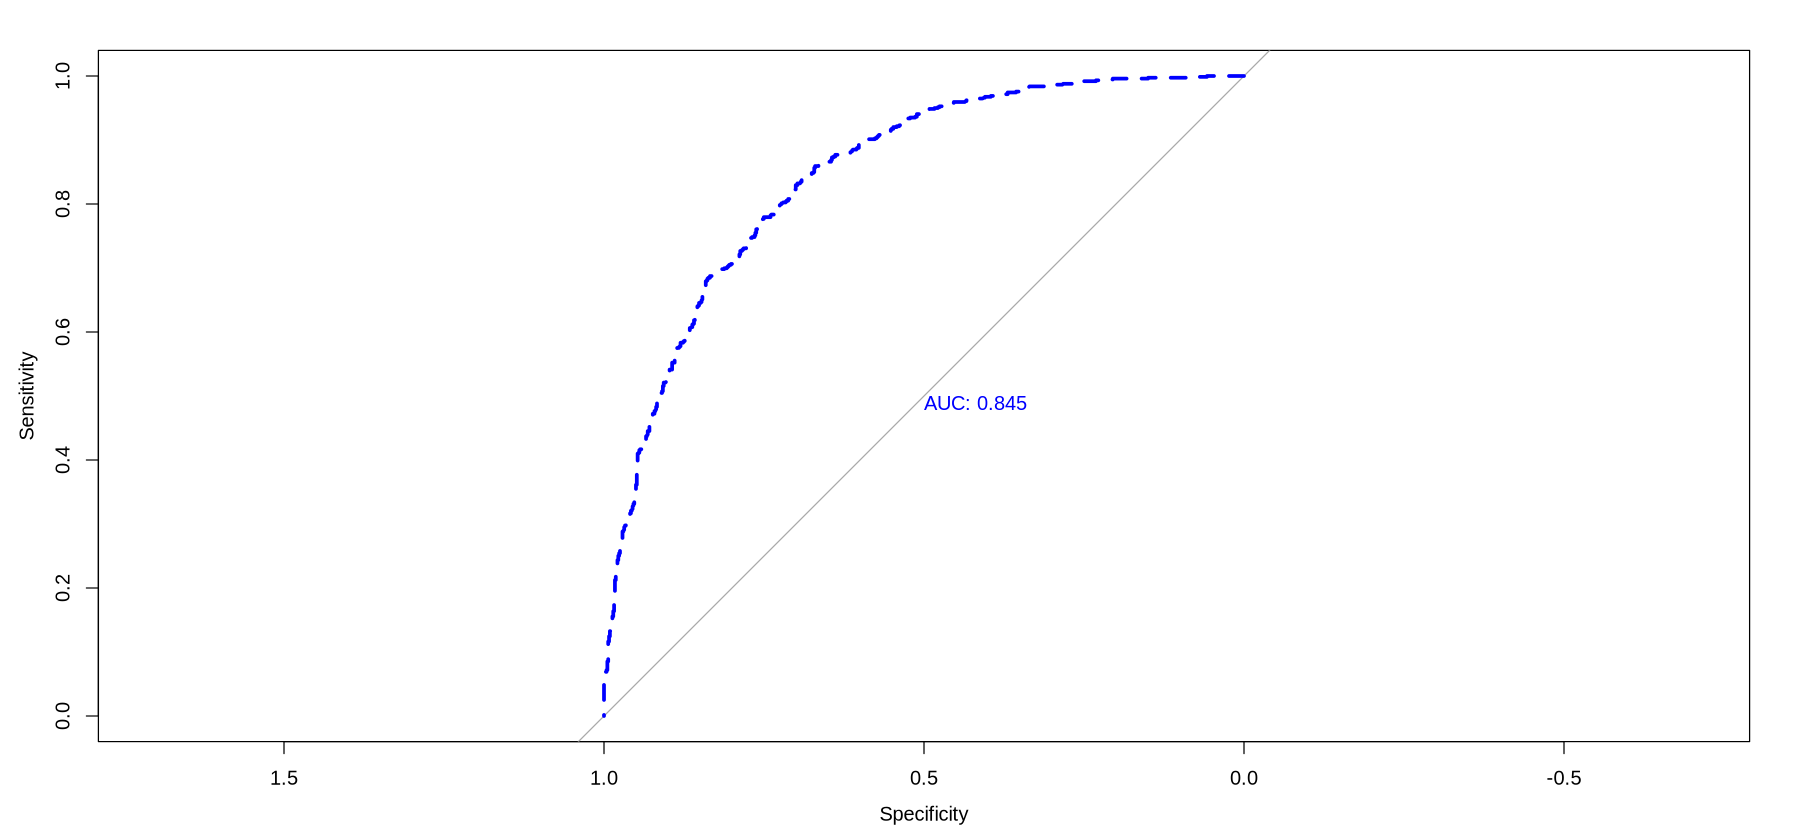

In [18]:
# Plotting the ROC curve
ROC_full_log <- roc(response = testing_set$income, predictor = testing_set$predicted_prob)

print("Fig.4: ROC Curves for Sample Census Dataset")
plot(ROC_full_log, print.auc = TRUE, col = "blue", lwd = 3, lty = 2)

## Discussion

### Summary and Impact of Findings

Overall, my logistic regression model shows that `age`, `education_num`, `hours_per_week`, and `sexMale` (being male) have positive coefficients, indicating that as these variables increase, so does the likelihood of earning more than $50K. It is also interesting to note that most occupations are negatively associated with the target income, except those in `Exec-managerial` or `Prof-specialty`. The model has a moderate accuracy of 76.13% and maintains a good balance between sensitivity and specificity, as evidenced by an F1 score of 0.7623. This balance is crucial for applications where the cost of misclassification is high, such as in medical diagnosis. The ROC curve for the Sample Census Dataset shows an AUC of 0.845, which indicates good predictive performance of the logistic regression model. The curve is significantly above the diagonal line of no discrimination, which would have an AUC of 0.5, demonstrating the model's effectiveness in distinguishing between the two income classes. This supports the conclusion that the selected features are meaningful for predicting income levels above \\$50K.

Given common socioeconomic patterns, the positive relationship between age, education, and income is not surprising. The strong effect of gender aligns with documented income disparities. The varying impact of occupations is also in line with expectations since different jobs offer different levels of pay. As a result, my logistic regression model performed fairly well, and my findings are consistent with what we already know about the socioeconomic factors that influence income. In this regard, I expect that my model will be useful to researchers studying income determinants, economists modeling labor market dynamics, or policymakers designing targeted interventions.

### Future Steps/Model Improvements 

Here are a few ways in which I could improve this model/project in the future:

- **Exploring Correlation/Interaction Among Variables:** For my logistic regression model presented in the implementation section, I didn’t include any of the interaction terms between the explanatory variables.

- **Refining Occupation Categories:** Some categories in the occupation variable have particularly high p-values, so removing them may improve the model prediction performance, but it may also bring unseen results.

- **Engaging in Feature Engineering:** Engaging in feature engineering can yield a more robust, accurate, and better interpretable model that captures the underlying problem.

### Future Question/Research

Here are some future questions/research these findings could lead to:

- **Extending the Study to Include Native Countries:** Extending the study to include the native country variable can reveal interesting patterns and insights, such as which factors are universally important for income prediction and which ones are country-specific.

- **Investigating the Relationship between Occupation, Education, and Income:** Understanding the correlation between occupation type, level of education, and income can help individuals make informed decisions about their education and career paths. It can also guide them towards occupations that align with their interests, and skills, and have the potential to provide a desired income. 

- **Analyzing the Impact of Work Hours on Income across Various Factors:** Exploring how factors such as age, gender, and education can influence the relationship between hours worked and income. Many jobs disproportionately reward working long hours, and the pay is often nonlinear. Jobs often penalize workers who choose to work fewer hours, and this reward structure tends to affect women of childbearing years disproportionately and affects their occupational choices. Understanding these dynamics can help inform policymakers to make decisions to promote a more equitable distribution of income.